In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import partial
from collections import deque
%matplotlib inline

In [2]:
class FindLanes:
    
    def __init__(self):
        self.search_start = -1
        self.search_end = -1
        self.error_counter = 0
        self.smooth_value = 10
        self.update_data = 10
        self.frame = 0
        self.left_curvature = 0
        self.right_curvature = 0
        self.off_center = 0
        self.leftx = deque(maxlen=self.smooth_value)
        self.lefty = deque(maxlen=self.smooth_value)
        self.rightx = deque(maxlen=self.smooth_value)
        self.righty = deque(maxlen=self.smooth_value)
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    
    def compute_calibartion_points(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('./camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        self.objpoints = objpoints
        self.imgpoints = imgpoints


    def undistort_image(self, img):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, 
                                                           (img.shape[1], img.shape[0]),None,None)
        return cv2.undistort(img, mtx, dist, None, mtx)


    def binary_pipeline(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        #combine
        color_binary = np.zeros_like(scaled_sobel)
        color_binary[(sxbinary == 1) | (s_binary ==1)] = 1
        return color_binary


    def warper(self, img):
        img_size = (img.shape[1], img.shape[0])
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
        return warped, Minv

    
    def get_histogram_points(self, binary_warped):
        if self.search_start == -1:
            search_start = 150
        else:
            search_start = self.search_start
        if self.search_end == -1:
            search_end = 1150
        else:
            search_end = min(self.search_end, binary_warped.shape[1])
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,search_start:search_end], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = search_start + np.argmax(histogram[:midpoint])
        rightx_base = search_start + np.argmax(histogram[midpoint:]) + midpoint

        return midpoint, leftx_base, rightx_base
    

    def polynomial_pipeline(self, binary_warped, Minv, image, nwindows=9, margin=100, minpix=50):
        # histogram of bottom 1/2
        midpoint, leftx_base, rightx_base = self.get_histogram_points(binary_warped)
        if rightx_base - leftx_base < 700:
            self.search_start = -1
            self.search_end = -1
            midpoint, leftx_base, rightx_base = self.get_histogram_points(binary_warped)
        self.search_start = max(leftx_base - margin, 0)
        self.search_end = rightx_base + margin

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions. x and y values
        self.leftx.append(nonzerox[left_lane_inds])
        self.lefty.append(nonzeroy[left_lane_inds]) 
        self.rightx.append(nonzerox[right_lane_inds])
        self.righty.append(nonzeroy[right_lane_inds])
        
        leftx = self.get_all_pixels(self.leftx)
        lefty = self.get_all_pixels(self.lefty)
        rightx = self.get_all_pixels(self.rightx)
        righty = self.get_all_pixels(self.righty)

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        if (self.frame % self.update_data == 0):
            self.get_curvature(binary_warped, lefty, leftx, righty, rightx)
            y_eval = binary_warped.shape[0]
            left_bot = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
            right_bot = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
            mid_bot = (left_bot + right_bot) / 2
            mid_photo = image.shape[1] / 2
            #positive is right of center. in meters
            self.off_center = (mid_bot - mid_photo) * self.xm_per_pix

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image,'Left Curvature: ' + str(int(self.left_curvature)),(10,60), font, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(image,'Right Curvature: ' + str(int(self.right_curvature)),(10,125), font, 2,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(image,'Center offset: ' + str(round(self.off_center,2)),(10,190), font, 2,(255,255,255),2,cv2.LINE_AA)
            
        return self.plot_on_road(binary_warped, image, left_fitx, right_fitx, ploty, Minv)
    

    def get_all_pixels(self, q):
        all_pixels = []
        for v in q:
            all_pixels.extend(v)
        return np.array(all_pixels)
    
    
    def plot_on_road(self, binary_warped, image, left_fitx, right_fitx, ploty, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        return cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    def process_image(self, img):
        undistort = self.undistort_image(img)
        binary = self.binary_pipeline(undistort)
        warped, Minv = self.warper(binary)
        on_road = self.polynomial_pipeline(warped, Minv, img)
        self.frame = self.frame + 1
        return on_road
    
    
    def get_binary_warped(self, img):
        undistort = self.undistort_image(img)
        binary = self.binary_pipeline(undistort)
        return self.warper(binary)
    
    
    def get_curvature(self, binary_warped, lefty, leftx, righty, rightx):
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix
        y_eval = binary_warped.shape[0]/2

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        self.left_curvature = left_curverad
        self.right_curvature = right_curverad

In [3]:
find_lanes = FindLanes()
find_lanes.compute_calibartion_points()

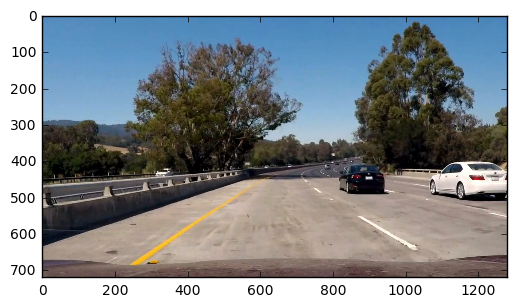

In [4]:
image = cv2.imread("error.jpg")
plt.imshow(image)

In [5]:
warped, minv = find_lanes.get_binary_warped(image)

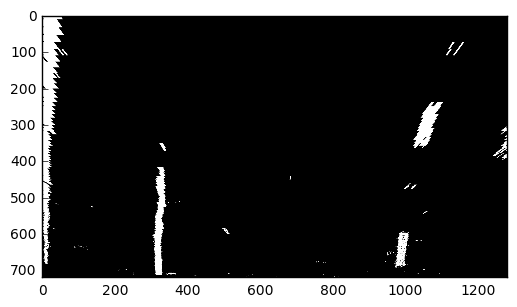

In [6]:
plt.imshow(warped, cmap="gray")

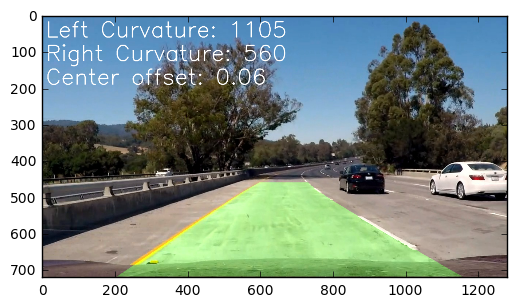

In [7]:
on_road = find_lanes.polynomial_pipeline(warped, minv, image)
plt.imshow(on_road)

## video

In [8]:
lanes_output = 'project_video_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")
lanes_clip = clip1.fl_image(find_lanes.process_image) #NOTE: this function expects color images!!
%time lanes_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video project_video_lines.mp4
[MoviePy] Writing video project_video_lines.mp4


100%|█████████▉| 1260/1261 [14:45<00:00,  1.40it/s]    | 1/1261 [00:00<13:02,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lines.mp4 

CPU times: user 34min 7s, sys: 1min 19s, total: 35min 26s
Wall time: 14min 46s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_output))